In [2]:
import os
from pathlib import Path

repo_root = Path.cwd()

while not (repo_root / ".git").exists() and repo_root.parent != repo_root:
    repo_root = repo_root.parent

os.chdir(repo_root)
print(f"Current working directory set to: {repo_root}")

Current working directory set to: c:\Users\Lenovo\Desktop\Git Uploads\cross-currency-extrema-forecasting


In [2]:
from src.features import FeatureCalculator
from src.features import FeatureSelector
from src.data.split_data import DatasetSplitter
import pandas as pd

# --- 1️⃣ Load your labeled dataset ---
df = pd.read_parquet("data/processed/labeled_data.parquet")

In [3]:
# --- 2️⃣ Compute all features ---
fc = FeatureCalculator(df)
df_features = fc.compute_all_features()

🕒 Starting feature computations...
📊 Computing return figures...
📊 Computing volatility metrics...
📊 Computing microstructure features...
📊 Computing technical indicators...
📊 Computing cross-currency correlations...
📊 Computing time features...
✅ All features computed.



In [4]:
# --- 3️⃣ Initialize FeatureSelector ---
feature_selector = FeatureSelector(df_features)

# --- 4️⃣ Orthogonalize features via PLS ---
df_orthogonal = feature_selector.orthogonalize_features()

🔹 Performing PLS-based orthogonalization...
✅ Orthogonalized 46 features into 46 PLS components.


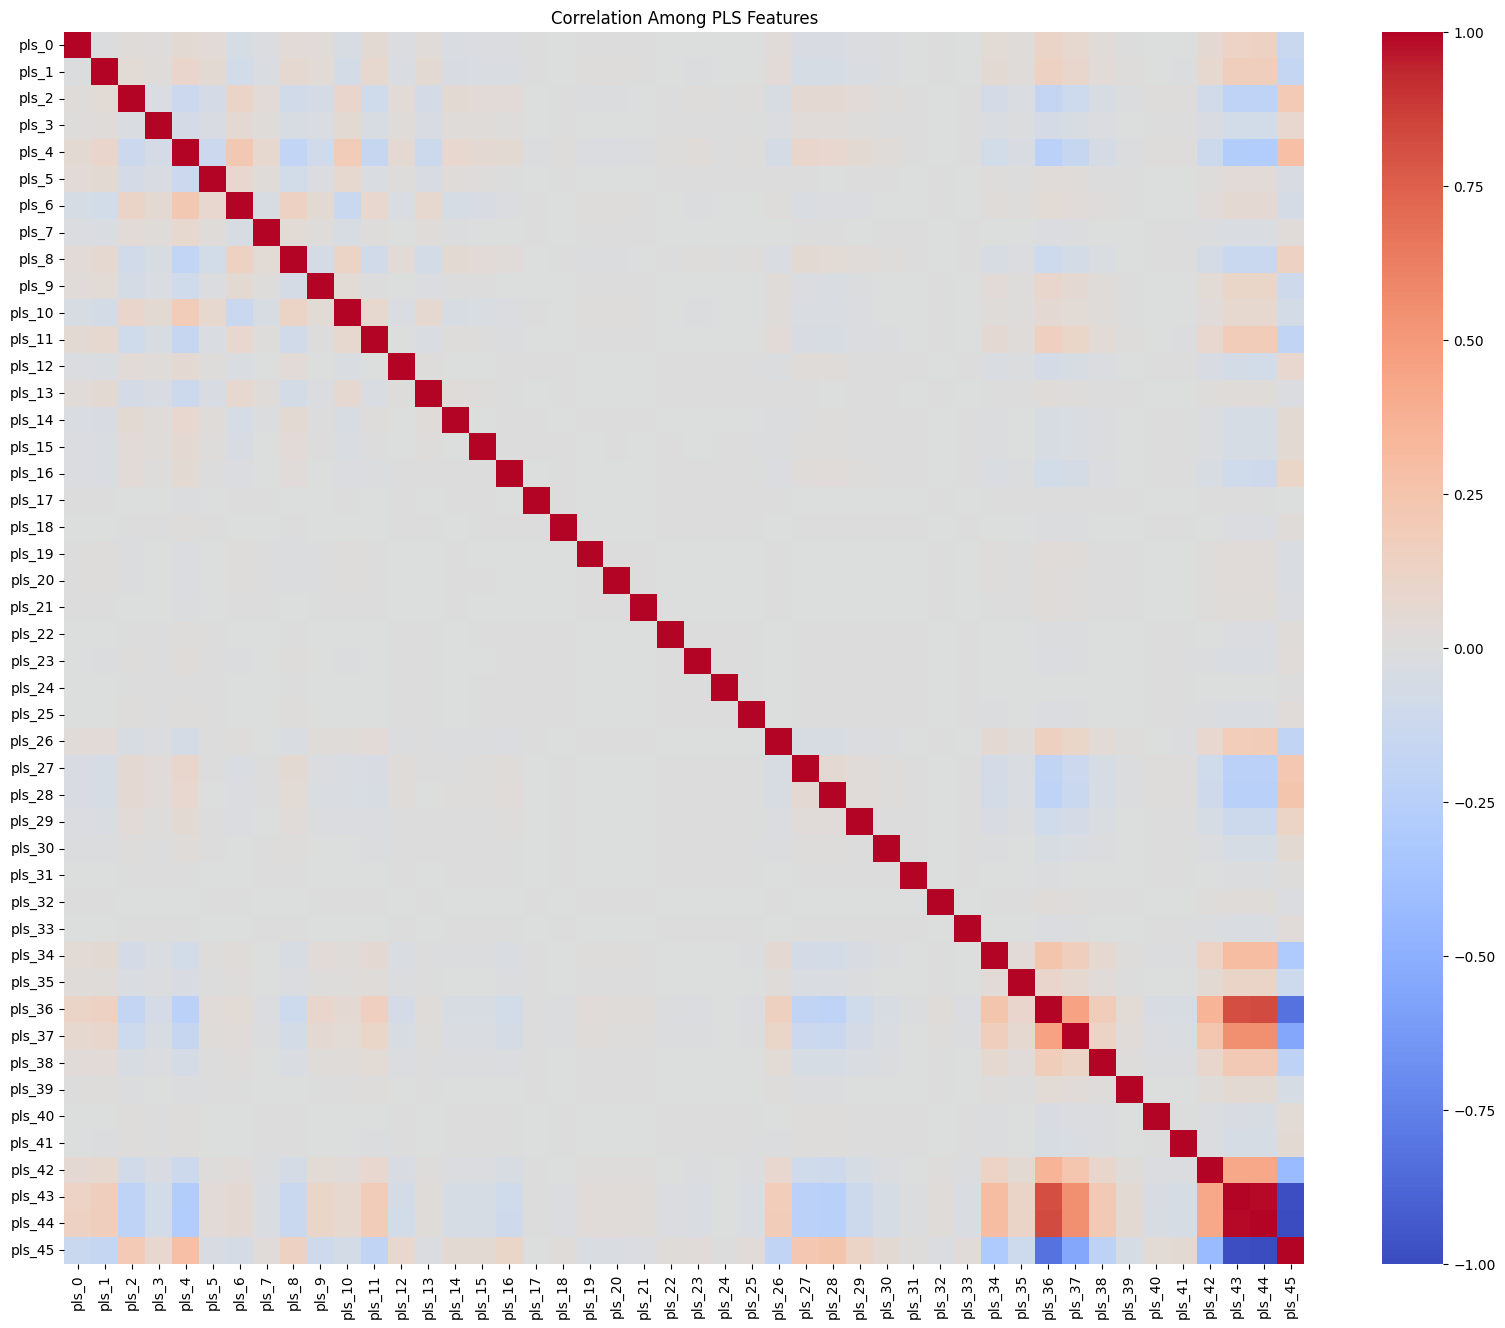

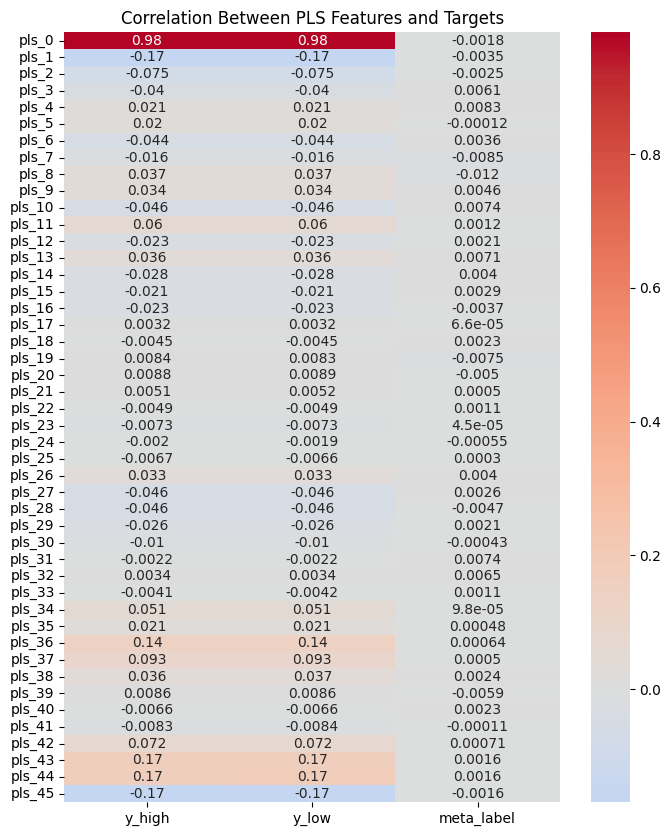

✅ Selected 3 PLS components after filtering and redundancy removal.


['pls_0', 'pls_1', 'pls_45']

In [5]:
# --- 5️⃣ Select relevant and non-redundant features ---
feature_selector.plot_mrmr_heatmaps()
feature_selector.select_pls_components()

In [6]:
df_final = df_orthogonal[feature_selector.selected_features + feature_selector.targets]

In [7]:
df_final.to_parquet("data/processed/final_features.parquet", index=True)

In [7]:
data_splitter = DatasetSplitter()
train, val, test = data_splitter.split(df_final)

🔹 Splitting dataset by currency with embargo...
✅ Split dataset: 2,129,901 train | 456,408 val | 395,565 test (embargo ~1.00% per currency)


In [8]:
train.to_parquet("data/split/train.parquet", index=True)
val.to_parquet("data/split/val.parquet", index=True)
test.to_parquet("data/split/test.parquet", index=True)